In [6]:
import joblib
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from tensorflow.keras.models import load_model

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')


# --- Filenames for the saved model and scaler ---
MODEL_FILE = 'seizure_model.keras' # Updated to .keras
SCALER_FILE = 'scaler.joblib'

def load_prediction_system():
    """Loads the trained model and scaler from disk."""
    try:
        # Load the Keras MLP model
        model = load_model(MODEL_FILE)
        # Load the scikit-learn scaler
        scaler = joblib.load(SCALER_FILE)
        print(f"Successfully loaded '{MODEL_FILE}' and '{SCALER_FILE}'.")
        return model, scaler
    except FileNotFoundError:
        print(f"Error: Could not find '{MODEL_FILE}' or '{SCALER_FILE}'.")
        print("Please run 'train_seizure_model.py' first to create these files.")
        return None, None
    except Exception as e:
        print(f"An error occurred while loading files: {e}")
        return None, None

def predict_seizure_likelihood(raw_data_row, model, scaler):
    """
    Predicts the likelihood of a seizure from a single row of raw data.
    
    :param raw_data_row: A 1D list or numpy array of the 178 features.
    :param model: The loaded Keras model.
    :param scaler: The loaded StandardScaler.
    :return: A float (0.0 to 1.0) representing the probability of a seizure.
    """
    # 1. Reshape the 1D row into a 2D array (scaler expects this)
    data_2d = np.array(raw_data_row).reshape(1, -1)
    
    # 2. Apply the *same* scaling that was used during training
    data_scaled = scaler.transform(data_2d)
    
    # 3. Get the probability from the Keras model
    # model.predict() with a sigmoid output gives the probability directly
    probabilities = model.predict(data_scaled, verbose=0)
    
    # 4. The output is an array like [[0.95]], so we extract the single value
    seizure_probability = probabilities[0][0]
    
    return float(seizure_probability)

# --- Main demonstration ---
if __name__ == "__main__":
    
    print("--- Seizure Prediction Runner (MLP Model) ---")
    model, scaler = load_prediction_system()

    if model and scaler:
        print("\n--- Demonstration ---")
        print("Loading sample data from the original CSV for demonstration...")
        
        try:
            # Load the original CSV to get sample rows
            df = pd.read_csv("Epileptic Seizure Recognition (1).csv")
            
            # Clean it just like in the training script
            if 'Unnamed' in df.columns[0]:
                df = df.drop(df.columns[0], axis=1)
            
            # Get a sample row that is a KNOWN SEIZURE (y == 1)
            seizure_sample_features = df[df['y'] == 1].iloc[0].drop('y').values
            
            # Get a sample row that is KNOWN NOT A SEIZURE (e.g., y == 5)
            non_seizure_sample_features = df[df['y'] == 5].iloc[0].drop('y').values

            # --- Prediction 1: Known Seizure ---
            prob1 = predict_seizure_likelihood(seizure_sample_features, model, scaler)
            print(f"\nPrediction for sample 1 (Known Seizure):")
            print(f"  -> Likelihood of seizure: {prob1 * 100:.2f}%")
            
            # --- Prediction 2: Known Non-Seizure ---
            prob2 = predict_seizure_likelihood(non_seizure_sample_features, model, scaler)
            print(f"\nPrediction for sample 2 (Known Non-Seizure):")
            print(f"  -> Likelihood of seizure: {prob2 * 100:.2f}%")

            # --- Prediction 3: Custom Data (example) ---
            custom_data = np.random.randint(-100, 100, size=seizure_sample_features.shape[0])
            prob3 = predict_seizure_likelihood(custom_data, model, scaler)
            print(f"\nPrediction for sample 3 (Custom/Random Data):")
            print(f"  -> Likelihood of seizure: {prob3 * 100:.2f}%")

        except FileNotFoundError:
            print("\nError: Could not find 'Epileptic Seizure Recognition (1).csv' to get sample data.")
        except Exception as e:
            print(f"\nAn error occurred during demonstration: {e}")

--- Seizure Prediction Runner (MLP Model) ---
Successfully loaded 'seizure_model.keras' and 'scaler.joblib'.

--- Demonstration ---
Loading sample data from the original CSV for demonstration...

Prediction for sample 1 (Known Seizure):
  -> Likelihood of seizure: 100.00%

Prediction for sample 2 (Known Non-Seizure):
  -> Likelihood of seizure: 0.01%

Prediction for sample 3 (Custom/Random Data):
  -> Likelihood of seizure: 0.01%


--- Seizure Prediction MLP Model Training ---
Loading dataset: 'Epileptic Seizure Recognition (1).csv'...
Preprocessing data...
Number of features: 178

Target distribution:
y_binary
0    9200
1    2300
Name: count, dtype: int64
Splitting data into training and testing sets...
Applying feature scaling (StandardScaler)...
Building the MLP (neural network) model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                11456     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                  

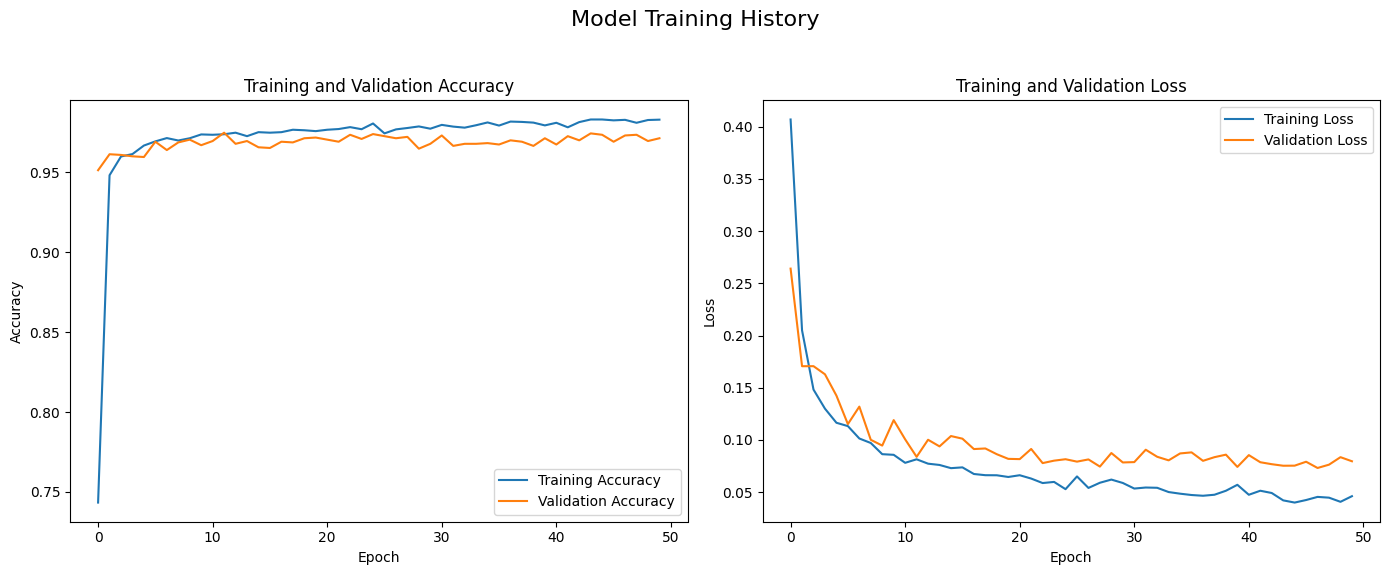

Generating confusion matrix plot...


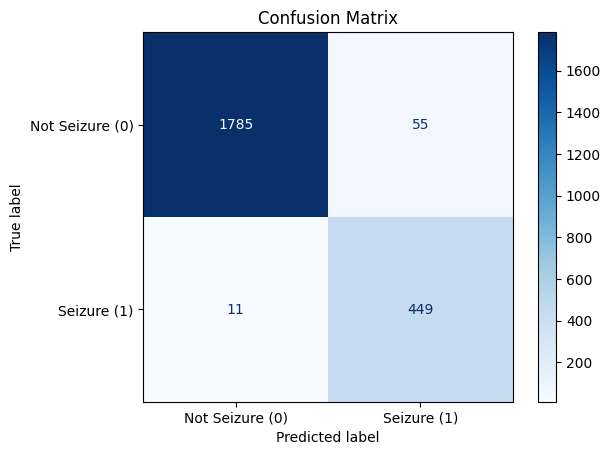

Saving model to 'seizure_model.keras' (Keras format)...
Saving scaler to 'scaler.joblib' (joblib format)...

--- Training Complete ---
Artifacts saved:
1. seizure_model.keras (The trained MLP model)
2. scaler.joblib (The data scaler)


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# Suppress TensorFlow logging
tf.get_logger().setLevel('ERROR')

print("--- Seizure Prediction MLP Model Training ---")

def plot_training_history(history):
    """Plots the training and validation accuracy and loss."""
    print("Generating training history plots...")
    
    # Get the data from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.suptitle('Model Training History', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_confusion_matrix(y_test, y_pred):
    """Plots the confusion matrix."""
    print("Generating confusion matrix plot...")
    
    cm = confusion_matrix(y_test, y_pred)
    target_names = ['Not Seizure (0)', 'Seizure (1)']
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

try:
    # --- 1. Load Dataset ---
    print("Loading dataset: 'Epileptic Seizure Recognition (1).csv'...")
    df = pd.read_csv("Epileptic Seizure Recognition (1).csv")

    # Drop the first column (e.g., 'Unnamed: 0' or 'ID')
    if 'Unnamed' in df.columns[0]:
        df = df.drop(df.columns[0], axis=1)

    # --- 2. Preprocess Data ---
    print("Preprocessing data...")
    # Convert to a binary classification problem:
    # 1 = Seizure
    # 0 = Not Seizure (Classes 2, 3, 4, 5)
    df['y_binary'] = df['y'].apply(lambda x: 1 if x == 1 else 0)

    # Define features (X) and target (y)
    X = df.drop(['y', 'y_binary'], axis=1)
    y = df['y_binary']
    
    n_features = X.shape[1]
    print(f"Number of features: {n_features}")
    
    print(f"\nTarget distribution:\n{y.value_counts()}")
    if (y == 1).sum() == 0:
        print("\nError: No samples found for class 1 (seizure). Please check your data.")
        exit()

    # --- 3. Train-Test Split ---
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )

    # --- 4. Feature Scaling ---
    print("Applying feature scaling (StandardScaler)...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- 5. Build the MLP Model ---
    print("Building the MLP (neural network) model...")
    model = Sequential()
    
    # Input Layer and First Hidden Layer
    model.add(Dense(64, input_dim=n_features, activation='relu'))
    model.add(Dropout(0.3))
    
    # Second Hidden Layer
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output Layer (Sigmoid for binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()

    # --- 6. Compile the Model ---
    print("Compiling model (adam optimizer, binary_crossentropy loss)...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Calculate class weights for imbalanced data
    # This is the equivalent of 'class_weight="balanced"'
    total = y_train.shape[0]
    pos = y_train.sum()
    neg = total - pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    print(f"Class weights: {class_weight}")

    # --- 7. Train the Model ---
    print("Training the MLP model...")
    history = model.fit(
        X_train_scaled, 
        y_train, 
        validation_data=(X_test_scaled, y_test), 
        epochs=50,       # You can increase this if needed
        batch_size=32,
        class_weight=class_weight, # Apply class weights
        verbose=0  # Set to 1 for more detail during training
    )

    # --- 8. Evaluate Model ---
    print("\n--- Model Evaluation (on Test Set) ---")
    # Get predictions (as probabilities)
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    # Convert probabilities to class labels (0 or 1)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    print(classification_report(y_test, y_pred, target_names=['Not Seizure (0)', 'Seizure (1)']))

    # --- 9. Generate Visualizations ---
    plot_training_history(history)
    plot_confusion_matrix(y_test, y_pred)

    # --- 10. Save Model and Scaler ---
    model_filename = 'seizure_model.keras'
    scaler_filename = 'scaler.joblib'
    
    print(f"Saving model to '{model_filename}' (Keras format)...")
    model.save(model_filename)
    
    print(f"Saving scaler to '{scaler_filename}' (joblib format)...")
    joblib.dump(scaler, scaler_filename)
    
    print("\n--- Training Complete ---")
    print(f"Artifacts saved:\n1. {model_filename} (The trained MLP model)\n2. {scaler_filename} (The data scaler)")

except FileNotFoundError:
    print("\nError: The file 'Epileptic Seizure Recognition (1).csv' was not found.")
    print("Please make sure it's in the same directory as this script.")
except Exception as e:
    print(f"\nAn error occurred: {e}")